Restarted deeponets-e-cU7SYa-py3.12 (Python 3.12.2)

In [ ]:
"""
This experiment shows how to use the NOMADDeepONet model to learn the antiderivative operator.
"""
#%%
import wget
import os 
from deeponets.models import  DeepONet, NOMDADDeepONet
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import trange
import matplotlib.pyplot as plt 

In [ ]:
wget.download("https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz")
wget.download("https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz")

'antiderivative_aligned_test (4).npz'

In [ ]:
class DeepONetData(Dataset):
    """
    From: https://github.com/JohnCSu/DeepONet_Pytorch_Demo/blob/main/DeepONet.ipynb
    """
    def __init__(self,y,u,Guy):
        self.y = y
        self.u = u
        self.Guy = Guy
    def __len__(self):
        return self.y.shape[0]
    def __getitem__(self,idx):
        return self.y[idx],self.u[idx],self.Guy[idx]
    
def process(dataset, *arg, **kwargs)->DataLoader:
    """
    See https://docs.pytorch.org/docs/stable/data.html for extra arguments.
    """
    # Branch: f(x)
    branch_train = torch.tensor(dataset["X"][0]).float() # Shape: (batch=150, n_sensor=100) 
    
    # Trunk: x
    trunk_train = torch.tensor(dataset["X"][1]).float() # Shape: (n_query=100,query_dim=1)
    trunk_train = trunk_train.unsqueeze(0).repeat(branch_train.shape[0],1,1) # (batch=150, n_query=100, query_dim=1)

    # Output: G(f)(x)
    outputs_train = torch.tensor(dataset["y"]).float()

    # Dataloader
    data = DeepONetData(trunk_train, branch_train, outputs_train)
    dataloader = DataLoader(data, *arg, **kwargs)
    return dataloader


# loade data
dataset_train = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
dataset_test = np.load("antiderivative_aligned_test.npz", allow_pickle=True)

dataloader_train = process(dataset_train, batch_size=50, shuffle=True, pin_memory=True)
dataloader_test = process(dataset_test, batch_size=50, shuffle=False, pin_memory=True)


# Show data
trunk_train, branch_train, outputs_train = next(iter(dataloader_train)) 
print('trunk', trunk_train.shape)
print('branch', branch_train.shape)
print('output', outputs_train.shape)  

trunk torch.Size([50, 100, 1])
branch torch.Size([50, 100])
output torch.Size([50, 100])


In [ ]:
model = NOMDADDeepONet(
    n_branch=branch_train.shape[-1], 
    n_trunk=trunk_train.shape[-1], 
    n_inter=100, 
    hiddens_branch=[10, 10], 
    hiddens_trunk=[10, 10],
    activation=torch.nn.ReLU(),
    final_activation_branch=torch.nn.Identity(),
    final_activation_trunk=torch.nn.Identity(),
    ln=False
).cuda()


optimiser = torch.optim.Adam(model.parameters(),lr = 1e-4)
lr_sch = torch.optim.lr_scheduler.StepLR(optimiser,1000,0.95)
criterion = torch.nn.MSELoss()

trng = trange(3000, desc="Training Progress", leave=True)

# Training
model.train()
for epoch in trng:
    for (y,u,Guy) in iter(dataloader_train):
        y, u, Guy = y.cuda(), u.cuda(), Guy.cuda()

        out = model(u,y)
        loss = criterion(out.squeeze(), Guy)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        lr_sch.step()
        # Display
        trng.set_description(f"Epoch {epoch+1} - Train Loss: {loss.item():.4e}")

Epoch 3000 - Train Loss: 5.3894e-04: 100%|██████████| 3000/3000 [00:21<00:00, 142.32it/s]


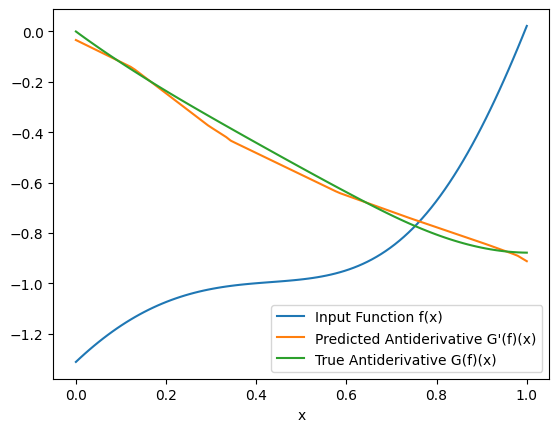

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for (y,u,Guy) in iter(dataloader_test):
        y, u, Guy = y.cuda(), u.cuda(), Guy.cuda()
        out = model(u,y)
        y_pred.append(out.squeeze().cpu().numpy())
        y_true.append(Guy.cpu().numpy())
    
fig, ax = plt.subplots()
ax.plot(y[0,:,0].cpu().numpy(), u[0,:].cpu().numpy(), label='Input Function f(x)')
ax.plot(y[0,:,0].cpu().numpy(),out[0,:,0].cpu().numpy(), label="Predicted Antiderivative G\'(f)(x)")
ax.plot(y[0,:,0].cpu().numpy(), Guy[0,:].cpu().numpy(), label="True Antiderivative G(f)(x)")
ax.set_xlabel('x')
ax.legend()